# Predict which voter-eligible Colorado citizens actually voted in the 2016 US presidential election.

This is the Spring 2017, Harvard Statistics 149: Generalized Linear Models prediction contest/course project.

The goal of this project is to use the modeling methods you learned in Statistics 149 (and possibly other related methods) to analyze a data set on whether a Colorado voting-eligible citizen ended up actually voting in the 2016 US election. These data were kindly provided by moveon.org. Competition can be found [here](inclass.kaggle.com/c/who-voted) and ended April 30, 2017, at 10pm EDT.

## Model training

The goal of this notebook is to build the models we will use to predict Colorado voter turnout in the 2016 election.

This is the fourth notebook for this competition. See [part 1](who-voted_EDA.ipynb) and [part 2](who-voted_features.ipynb) for initial exploration of the data and [part 3](who-voted_impute.ipynb) for data imputation.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint as sp_randint
from scipy import interp
from itertools import cycle

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.externals import joblib

[Local functions](https://github.com/yuwie10/who-voted/blob/master/who_voted_functions.py).

In [121]:
import who_voted_functions as wv
import importlib as imp
imp.reload(wv);

Load data and create X and y arrays.

In [3]:
train_imp = wv.load_data('train_imp.csv', compression = 'gzip')
train = wv.load_data('train_renamed.csv')

In [4]:
pd.set_option('max_columns', 100)
train_imp.head()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll,voted
0,M,7,31,36,U,Hispanic,25.4,63.4,54.0,16.7,16.5,39.6,27.3,420,2.658148,3.456541,Y
1,F,6,38,55,U,Uncoded,7.9,97.8,59.8,16.7,15.5,30.9,36.9,307,2.240415,2.130636,Y
2,F,2,53,24,U,Caucasian,50.2,7.6,49.5,14.6,24.0,29.6,31.7,292,2.332767,2.872147,Y
3,F,7,30,25,D,Caucasian,38.0,8.5,47.4,13.1,22.3,33.3,31.4,316,2.983480,3.193841,Y
4,M,5,19,22,R,Caucasian,30.5,19.1,23.1,16.0,10.5,39.1,34.5,392,3.160107,3.841248,Y


In [5]:
y_vector = wv.get_y_vector(train_imp, 'voted')

quant, categ = wv.get_cols(train_imp)
X_matrix = wv.design_Xmatrix(train_imp, quant, categ)

y_vector.shape
X_matrix.shape

(118529,)

(118529, 98)

We have to decide on an appropriate k for k-fold cross validation. Let's plot the ROC curves for different cv splits to select the best k. Code adapted from [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html).

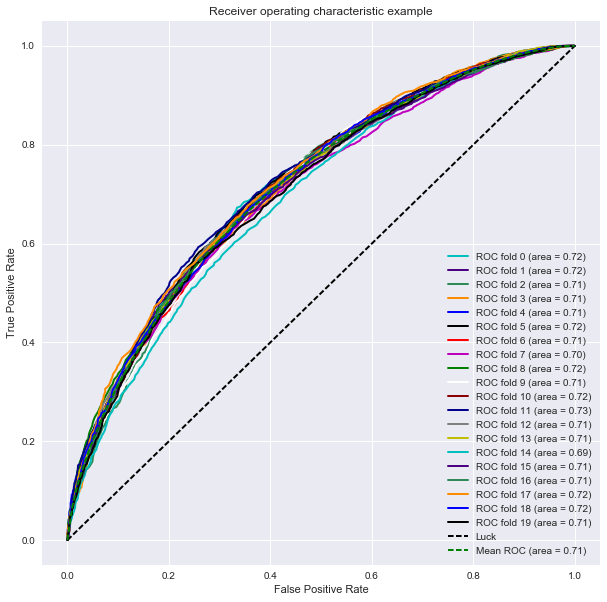

In [28]:
clf = RandomForestClassifier(n_estimators = 500)
cv = StratifiedKFold(n_splits = 20)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['c', 'indigo', 'seagreen', 'darkorange', 'b', 'k', 'r', 'm', 
               'g', 'w', 'darkred', 'darkblue', 'grey', 'y'])
lw = 2
fig, ax = plt.subplots()
fig.set_size_inches(10, 10);

i = 0
for (train, test), color in zip(cv.split(X_matrix, y_vector), colors):
    probas_ = clf.fit(X_matrix[train], y_vector[train]).predict_proba(X_matrix[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_vector[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    _ = plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc));
    i += 1
    
_ = plt.plot([0, 1], [0, 1], linestyle = '--', lw = lw, color = 'k', label = 'Luck');

mean_tpr /= cv.get_n_splits(X_matrix, y_vector)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
_ = plt.plot(mean_fpr, mean_tpr, color = 'g', linestyle = '--',
             label = 'Mean ROC (area = {%0.2f})'.format(mean_auc), lw = lw);

_ = plt.xlim([-0.05, 1.05]);
_ = plt.ylim([-0.05, 1.05]);
_ = plt.xlabel('False Positive Rate');
_ = plt.ylabel('True Positive Rate');
_ = plt.title('Receiver operating characteristic example');
_ = plt.legend(loc = "lower right");

The cv splits are similar, although the best split is cv = 11.

In [6]:
cv = StratifiedKFold(n_splits = 11, random_state = 123)

## Hyperparameter tuning

The performance of random forests is known to increase substantially following hyperparameter tuning. We will test Bayesian optimization of hyperparameter tuning, which seeks to maximize the explore/exploit tension in searching parameter space, provided by [SigOpt](sigopt.com). Code was adapted from [here](https://github.com/sigopt/sigopt-examples/blob/master/random-forest/python/Random Forest.ipynb).

In [30]:
from sigopt import Connection
conn = Connection(client_token = 'ZGILQJTPPAWFCOOOZPALZQHRKNBANVQQUEVEJJSYYOUVYNYI')

In [63]:
#create SigOpt experiment
experiment = conn.experiments().create(
  name="Who voted?",
  parameters=[
    dict(name="max_features", type="int", bounds=dict(min=1, max=(X_matrix.shape[1]-1))),
    dict(name="min_samples_leaf", type="int", bounds=dict(min=40, max=200)),
    dict(name='n_estimators', type='int', bounds=dict(min=100, max=500)),
    {
    'categorical_values':[
        {
            'enum_index':1,
            'name':'gini',
            'object':'categorical_value'
        },
        {
            'enum_index':2,
            'name':'entropy',
            'object':'categorical_value'
        }
    ],
    'default_value':'gini',
    'name':'criterion',
    'type':'categorical'
    },
    {
    'categorical_values':[
        {
            'enum_index':1,
            'name':'balanced',
            'object':'categorical_value'
        },
        {
            'enum_index':2,
            'name':'balanced_subsample',
            'object':'categorical_value'
        }
    ],
    'default_value':'balanced',
    'name':'class_weight',
    'type':'categorical'
    }
  ]
)
print("Created experiment: https://sigopt.com/experiment/" + experiment.id)

Created experiment: https://sigopt.com/experiment/17994


In [64]:
def evaluate_model(assignments, X, y, cv):
    '''
    
    Inputs:
    assignments = suggested parameters from SigOpt
    X and y matrices
    cv = cross-validation scheme
    
    Returns: mean and std of cv accuracies
    '''
    classifier = RandomForestClassifier(n_estimators = assignments['n_estimators'],
                                        max_features = assignments['max_features'], 
                                        min_samples_leaf = assignments['min_samples_leaf'],
                                        criterion = assignments['criterion'],
                                        class_weight = assignments['class_weight'],
                                        random_state = 123,
                                       )
    cv_accuracies = cross_val_score(classifier, X, y, cv = cv)
    return (np.mean(cv_accuracies), np.std(cv_accuracies))

In [ ]:
for _ in range(20):
    # Receive a Suggestion from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    # Evaluate the model locally
    (value, std) = evaluate_model(suggestion.assignments, X_matrix, y_vector, cv)

    # Report an Observation (with standard deviation) back to SigOpt
    _ = conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
        value_stddev=std,
    );

In [60]:
# Re-fetch the best observed value and assignments
best_assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments
best_assignments

Assignments({
  "class_weight": "balanced_subsample",
  "criterion": "entropy",
  "max_features": 102,
  "min_samples_leaf": 1,
  "n_estimators": 500
})

In [7]:
rf_1 = RandomForestClassifier(n_estimators = 500,
                              #changed to None because number of features changed from initial training
                              max_features = None, 
                              min_samples_leaf = 1,
                              class_weight = 'balanced_subsample',
                              criterion = 'entropy',
                              random_state = 123)

## High-cardinal variables

As already noted, there are 65 distinct categories for the state house district variable. Combined with the categories from the other nominal variables results in 87 dummy coded variables and a much higher-dimension dataset than we originally started with. This is especially problematic for tree-based models, as the sparseness of the feature space makes it difficult to achieve a good fitting model. 

To incorporate these predictors without having to worry about this problem, we can transform the variables with more than 5 categories to continuous variables using either supervised ratio (SR) or weight of evidence (WOE) (see [here](http://www.kdnuggets.com/2016/08/include-high-cardinality-attributes-predictive-model.html)). Therefore race, state_house and congress_district are transformed. Although race and congress_district do not have a large number of categories (11 and 6, respectively), because there are only 16 predictors total, coding these two predictors as factors would still mean over half the predictors are dummy variables.

In [8]:
#total number of those who did or did not vote
voted_counts = train_imp['voted'].value_counts()

card_cols = ['congress_district', 'state_house', 'race']
ratios = []
woes = []
for i in card_cols:
    sr, woe = wv.transform_to_continuous(train_imp, i, voted_counts)
    ratios.append(sr)
    woes.append(woe)

train_ratio = wv.create_card_df(train_imp, card_cols, ratios)
train_woe = wv.create_card_df(train_imp, card_cols, woes)

To check whether SR and WOE result in similar transformations, let's plot the two transformations against one another. Although they are on different scales, the transformations if done properly should result in a 1:1 relationship.

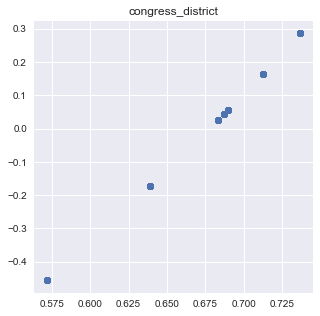

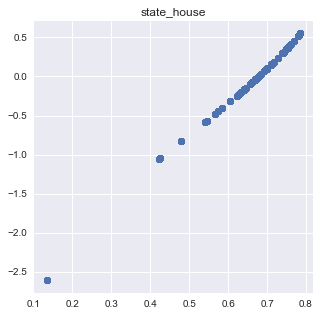

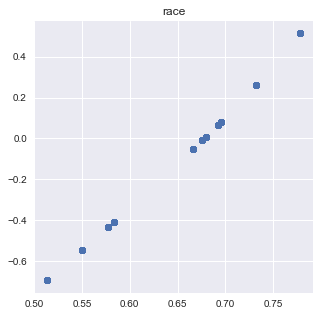

In [9]:
for col in card_cols:
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5);
    _ = plt.plot(train_ratio[col], train_woe[col], 'o');
    _ = plt.title(col);

We can also investigate the distribution of the transformed variables. Values of a cardinal variable associated with an above average likelihood of voting will have a positive WOE transformation, while those with a less than average likelihood of voting will have negative transformations.

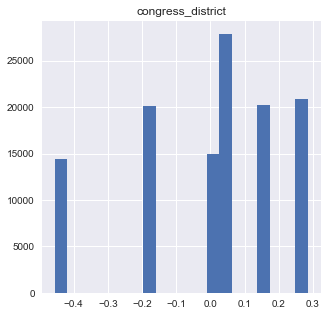

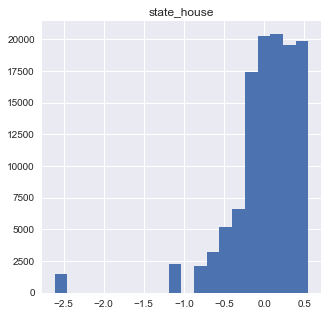

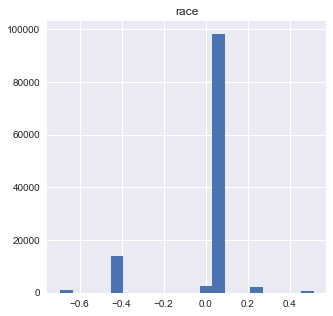

In [10]:
for col in card_cols:
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5);
    _ = plt.hist(train_woe[col], bins = 20);
    _ = plt.title(col);

We can see that for all variables, the majority of categories are neither more associated with voting or not voting, although there are a few categories above or below average, especially for state_house.

We are now ready to train and test our classifiers.

## Training random forest models

Let's first train the random forest whose hyperparameters we tuned using SigOpt and test its performance on the following design matrices (4 total):

1. SR vs. WOE transformation of cardinal variables + imputed data
2. SR vs. WOE transformation without imputed data

In [11]:
quant_card, categ_card = wv.get_cols(train_ratio)
quant_card_nodist = quant_card.copy()
quant_card_nodist.remove('dist_ballot')
quant_card_nodist.remove('dist_poll')

In [12]:
#supervised ratio + imputed data
X_ratio_imputed = wv.design_Xmatrix(train_ratio, quant_card, categ_card, standardize = True)

#supervised ratio, no imputed data
X_ratio = wv.design_Xmatrix(train_ratio, quant_card_nodist, categ_card, standardize = True)

#woe + imputed data
X_woe_imputed = wv.design_Xmatrix(train_woe, quant_card, categ_card, standardize = True)

#woe, no imputed data
X_woe = wv.design_Xmatrix(train_woe, quant_card_nodist, categ_card, standardize = True)

In [812]:
Xs = [X_matrix, X_ratio_imputed, X_ratio, X_woe_imputed, X_woe]

for X in Xs:
    wv.cross_val_LL(rf_1, X, y_vector, cv)

(-0.56585201611143254, 0.0043669852965324309)

(-0.56475857501580007, 0.0040639826944698131)

(-0.56716838753077814, 0.0038353064465207077)

(-0.56475814157433202, 0.0040644929405302078)

(-0.56716748168974784, 0.0038373713667522579)

The log-loss scores are relatively similar, although the best scores come from the models trained on the transformed predictors (X_ratio_imputed and X_woe_imputed). The most principled method would be to tune hyperparameters for each design matrix and compare the resulting log-losses, but for time considerations we will use the random forest trained on the imputed and WOE transformed design matrix for our first submission.

Let's load the test set and transform the cardinal variables using the WOE method.

In [13]:
test_imp = wv.load_data('test_imp.csv', compression = 'gzip')
test_imp.head()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll,Id
0,M,2,52,30,L,Caucasian,19.5,21.2,25.3,9.8,16.6,45.2,28.4,393,2.521099,2.770852,1
1,F,5,19,20,U,Caucasian,39.7,20.2,29.1,12.0,14.4,41.4,32.2,668,3.143472,3.972788,2
2,M,4,44,56,R,Caucasian,11.3,62.7,41.3,14.8,14.7,36.0,34.6,606,2.736109,2.859035,3
3,F,7,34,20,R,Caucasian,32.8,11.6,33.1,14.5,10.3,44.6,30.6,565,2.136312,2.329654,4
4,F,6,41,26,D,Uncoded,10.2,14.7,22.4,8.2,18.4,43.5,29.9,336,2.785245,2.904892,5


In [14]:
#drop 'voted' column from train set and 'Id' column from test set and merge
all_data = train_imp.drop('voted', axis = 1).append(test_imp.drop('Id', axis = 1))
all_data.shape
all_data.head()

(158039, 16)

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll
0,M,7,31,36,U,Hispanic,25.4,63.4,54.0,16.7,16.5,39.6,27.3,420,2.658148,3.456541
1,F,6,38,55,U,Uncoded,7.9,97.8,59.8,16.7,15.5,30.9,36.9,307,2.240415,2.130636
2,F,2,53,24,U,Caucasian,50.2,7.6,49.5,14.6,24.0,29.6,31.7,292,2.332767,2.872147
3,F,7,30,25,D,Caucasian,38.0,8.5,47.4,13.1,22.3,33.3,31.4,316,2.983480,3.193841
4,M,5,19,22,R,Caucasian,30.5,19.1,23.1,16.0,10.5,39.1,34.5,392,3.160107,3.841248


In the training set we replaced each distinct value of the high-cardinal variables based on how often an instance was associated with a person who did or did not vote. We will replace the cardinal variables in the test set with those from the training dataset using WOE transformation.

In [16]:
all_woe = wv.create_card_df(all_data, card_cols, woes)

#create a df 
X_df = wv.design_Xmatrix(all_woe, quant_card, categ_card, standardize = True, matrix = False)
X_df.tail()

,congress_district,state_house,age,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll,gender_M,gender_U,party_G,party_L,party_O,party_R,party_U
39505,0.072158,0.632641,1.295414,0.335624,0.928300,0.158591,-0.283506,0.521830,2.186790,-1.508472,-0.356047,-1.445074,-0.439574,-0.278821,0,0,0,0,0,0,0
39506,1.242733,0.782801,-1.001241,0.335624,2.783143,-1.184228,0.415447,0.148974,1.551485,-1.108965,0.178138,-1.362826,-0.413931,-0.128204,0,0,0,0,0,1,0
39507,1.242733,0.868673,0.529862,-2.425627,-1.080555,0.736793,1.522122,-0.698427,-1.516573,1.478321,-0.436175,-0.677424,-0.623841,-0.687215,1,0,0,0,0,0,0
39508,-2.080612,-0.538028,-1.065037,-2.425627,1.892551,-1.155792,-0.696083,6.673957,-0.788297,-1.898467,-3.854962,-0.037715,-0.594482,-0.759875,0,0,0,0,0,0,1
39509,-2.080612,-0.005997,-1.065037,0.335624,1.350160,-0.865111,-0.739767,-0.376415,-0.245963,0.441505,-0.222501,1.159454,-0.550899,-0.673335,1,0,0,0,0,0,1


In [18]:
train_imp.shape
test_imp.shape

(118529, 17)

(39510, 17)

In [19]:
X_train_full = X_df.iloc[:118529, ].as_matrix()
X_test_full = X_df.iloc[118529:, ].as_matrix()

**Note:** Although all submissions were trained and tested on the set where standardization was performed using both the test and train set, in retrospect, the test set should have been standardized *separately* from the training set to assess the full predictive performance of the models.

In [20]:
rf_1_fit = rf_1.fit(X_train_full, y_vector)
series_id = test_imp['Id']
to_submit = wv.for_submission(rf_1_fit, X_test_full, series_id, 1)
to_submit.head()

,Id,voted
0,1,0.626
1,2,0.558
2,3,0.764
3,4,0.526
4,5,0.864


This first submission resulted in a log-loss score of 0.56252 on the public leaderboard and a score of 0.56227 on the private leaderboard. For brevity and clarity submissions that did not result in improved log-loss scores relative to previous submissions will be omitted from this notebook, as they mainly involved tuning of hyperparameters.

## Training logistic regression

For binary response predictions, logistic regression also often performs well.

In [21]:
#re-define cv splits with shuffle = True
kfold = StratifiedKFold(n_splits = 11, shuffle = True, random_state = 7)

In [22]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clf = GridSearchCV(LogisticRegression(random_state = 7), 
                   param_grid, scoring = 'neg_log_loss', cv = kfold)
clf.fit(X_woe_imputed, y_vector)

clf.best_params_

GridSearchCV(cv=StratifiedKFold(n_splits=11, random_state=7, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

{'C': 0.1}

In [23]:
logit = LogisticRegression(random_state = 7, C = 0.1)
wv.cross_val_LL(logit, X_woe_imputed, y_vector, kfold)

(-0.56823770024757259, 0.0035349868155999968)

The performance of logistic regression can suffer more from inclusion of extraneous or highly correlated variables. Let's examine the correlation matrix again.

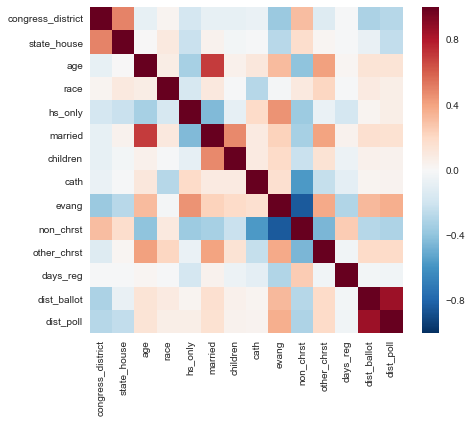

In [232]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 6);
sns.heatmap(train_woe.corr());

Let's test whether removing certain correlated predictors improves performance of logistic regression.

In [141]:
cols_remove = ['congress_district', 'age', 'dist_poll', 'non_chrst', 'other_chrst']
train_no_corr = train_woe.drop(cols_remove, axis = 1)

quant_corr, categ_corr = wv.get_cols(train_no_corr)
X_no_corr = wv.design_Xmatrix(train_no_corr, quant_corr, categ_corr,
                             standardize = True)

In [142]:
wv.cross_val_LL(logit, X_no_corr, y_vector, kfold)

(-0.56864956169628467, 0.00354391352181419)

The log-loss score when the 5 most correlated features are eliminated is higher than when all the features are included. Although we could potentially get a lower log-loss by testing different combinations of predictors, it does not seem like logistic regression on this dataset is likely to perform better than random forest. This is probably due to the non-linear relationships we saw in the pairplot in [part 1](who_voted_EDA.ipynb).

## Gradient boosted trees

Although random forests are generally good out-of-the-box classifiers, it is known that gradient boosted trees often outperform random forests. As opposed to random forests, which grow full decision trees trained on bootstrapped (and ideally highly uncorrelated) subsamples of the data, gradient boosted trees are an ensemble of weak learners, each of which is trained on the errors of the previous tree. Hyperparameter tuning is particularly important for these models. We start by tuning the maximum depth of the individual trees, total number of trees, the learning rate and gamma (both of which control model complexity and therefore can help prevent overfitting).

In [28]:
#create SigOpt experiment
experiment = conn.experiments().create(
  name='Who voted?',
  parameters=[
    dict(name='max_depth', type='int', bounds=dict(min=1, max=9)),
    dict(name='n_estimators', type='int', bounds=dict(min=50, max=500)),
    dict(name='learning_rate', type='double', bounds=dict(min=0.001, max=0.3)),
    dict(name='gamma', type='double', bounds=dict(min=0, max=10))
  ]
)
print("Created experiment: https://sigopt.com/experiment/" + experiment.id)

Created experiment: https://sigopt.com/experiment/18408


In [34]:
def evaluate_model(assignments, X, y, cv):
    '''
    Evaluates different Random Forest models with different hyperparameters.
    
    Inputs:
    assignments = suggested parameters from SigOpt
    X and y matrices
    cv = cross-validation scheme
    
    Returns: mean and std of cv log loss
    '''
    classifier = XGBClassifier(max_depth = assignments['max_depth'],
                               n_estimators = assignments['n_estimators'],
                               learning_rate = assignments['learning_rate'],
                               gamma = assignments['gamma'],
                               seed = 7)
    cv_LL = cross_val_score(classifier, X, y, cv = kfold, scoring = 'neg_log_loss')
    return (np.mean(cv_LL), np.std(cv_LL))

In [35]:
for _ in range(50):
    # Receive a Suggestion from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    # Evaluate the model locally
    (value, std) = evaluate_model(suggestion.assignments, X_woe_imputed, y_vector, kfold)

    # Report an Observation (with standard deviation) back to SigOpt
    _ = conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
        value_stddev=std,
    );

# Re-fetch the best observed value and assignments
best_assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments
best_assignments

Assignments({
  "gamma": 3.3285290509838568,
  "learning_rate": 0.08654237617740236,
  "max_depth": 7,
  "n_estimators": 314
})

In [40]:
conn.experiments(experiment.id).best_assignments().fetch().data[0]

BestAssignments({
  "assignments": {
    "gamma": 3.3285290509838568,
    "learning_rate": 0.08654237617740236,
    "max_depth": 7,
    "n_estimators": 314
  },
  "metadata": null,
  "value": -0.5566347742985939,
  "value_stddev": 0.0034365479004968536,
  "values": [
    {
      "name": null,
      "object": "metric_evaluation",
      "value": -0.5566347742985939,
      "value_stddev": 0.0034365479004968536
    }
  ]
})

In [25]:
xgb_1 = XGBClassifier(max_depth = 7,
                      n_estimators = 314,
                      learning_rate = 0.08654237617740236,
                      gamma = 3.3285290509838568,
                      seed = 7)

xgb_1_fit = xgb_1.fit(X_train_full, y_vector)

In [53]:
to_submit3 = wv.for_submission(xgb_1_fit, X_test_full, series_id, 3)
to_submit3.tail()

,Id,voted
39505,39506,0.829266
39506,39507,0.853076
39507,39508,0.849594
39508,39509,0.445434
39509,39510,0.505540


This submission resulted in an improved public log-loss of 0.55157 and a private one of 0.55402.

Let's add in an L2 regularization term to further reduce variance in the model.

In [57]:
#create SigOpt experiment
experiment = conn.experiments().create(
  name='Who voted?',
  parameters=[
    dict(name='max_depth', type='int', bounds=dict(min=1, max=9)),
    dict(name='n_estimators', type='int', bounds=dict(min=50, max=500)),
    dict(name='learning_rate', type='double', bounds=dict(min=0.001, max=0.3)),
    dict(name='gamma', type='double', bounds=dict(min=0, max=10)),
    dict(name='reg_lambda', type='double', bounds=dict(min=1, max=10))
  ]
)
print("Created experiment: https://sigopt.com/experiment/" + experiment.id)

Created experiment: https://sigopt.com/experiment/18468


In [60]:
def evaluate_model(assignments, X, y, cv):
    '''
    Evaluates different Random Forest models with different hyperparameters.
    
    Inputs:
    assignments = suggested parameters from SigOpt
    X and y matrices
    cv = cross-validation scheme
    
    Returns: mean and std of cv log loss
    '''
    classifier = XGBClassifier(max_depth = assignments['max_depth'],
                               n_estimators = assignments['n_estimators'],
                               learning_rate = assignments['learning_rate'],
                               gamma = assignments['gamma'],
                               reg_lambda = assignments['reg_lambda'],
                               seed = 7)
    cv_LL = cross_val_score(classifier, X, y, cv = kfold, scoring = 'neg_log_loss')
    return (np.mean(cv_LL), np.std(cv_LL))

In [ ]:
for _ in range(60):
    # Receive a Suggestion from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    # Evaluate the model locally
    (value, std) = evaluate_model(suggestion.assignments, X_woe_imputed, y_vector, kfold)

    # Report an Observation (with standard deviation) back to SigOpt
    _ = conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
        value_stddev=std,
    );

In [62]:
# Re-fetch the best observed value and assignments
conn.experiments(experiment.id).best_assignments().fetch().data[0]
best_assignments2 = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments
best_assignments2

BestAssignments({
  "assignments": {
    "gamma": 2.8869657909958493,
    "learning_rate": 0.03311755173249714,
    "max_depth": 9,
    "n_estimators": 358,
    "reg_lambda": 9.925559973077503
  },
  "metadata": null,
  "value": -0.5555487877236724,
  "value_stddev": 0.0034731854503106843,
  "values": [
    {
      "name": null,
      "object": "metric_evaluation",
      "value": -0.5555487877236724,
      "value_stddev": 0.0034731854503106843
    }
  ]
})

Assignments({
  "gamma": 2.8869657909958493,
  "learning_rate": 0.03311755173249714,
  "max_depth": 9,
  "n_estimators": 358,
  "reg_lambda": 9.925559973077503
})

In [26]:
xgb_2 = XGBClassifier(max_depth = 9, 
                      n_estimators = 358,
                      learning_rate = 0.03311755173249714,
                      gamma = 2.8869657909958493,
                      reg_lambda = 9.925559973077503,
                      seed = 7)

xgb_2_fit = xgb_2.fit(X_train_full, y_vector)

In [65]:
to_submit4 = wv.for_submission(xgb_2_fit, X_test_full, series_id, 4)
to_submit4.tail()

,Id,voted
39505,39506,0.837693
39506,39507,0.858705
39507,39508,0.835815
39508,39509,0.439149
39509,39510,0.507000


Adding L2 regularization decreased the public log-loss score to 0.55104 and the private score to 0.55302.

Let's tune min_child_weight (number of weights required for a split) and add max_delta_step, which helps fit imbalanced classes, and subsample/colsample_bytree to control the fraction of samples to be sampled for each individual tree.

In [112]:
#create SigOpt experiment
experiment = conn.experiments().create(
  name='Who voted?',
  parameters=[
    dict(name='max_depth', type='int', bounds=dict(min=3, max=10)),
    dict(name='min_child_weight', type='int', bounds=dict(min=1, max=6)),
    dict(name='learning_rate', type='double', bounds=dict(min=0.01, max=0.1)),
    dict(name='gamma', type='double', bounds=dict(min=1, max=5)),
    dict(name='reg_lambda', type='double', bounds=dict(min=3, max=10))
  ]
)
print("Created experiment: https://sigopt.com/experiment/" + experiment.id)

Created experiment: https://sigopt.com/experiment/18564


In [114]:
def evaluate_model(assignments, X, y, cv):
    '''
    Evaluates different Random Forest models with different hyperparameters.
    
    Inputs:
    assignments = suggested parameters from SigOpt
    X and y matrices
    cv = cross-validation scheme
    
    Returns: mean and std of cv log loss
    '''
    classifier = XGBClassifier(max_depth = assignments['max_depth'],
                               n_estimators = 400,
                               learning_rate = assignments['learning_rate'],
                               min_child_weight = assignments['min_child_weight'],
                               gamma = assignments['gamma'],
                               max_delta_step = 1,
                               subsample = 0.8,
                               colsample_bytree = 0.8,
                               reg_lambda = assignments['reg_lambda'],
                               seed = 7)
    cv_LL = cross_val_score(classifier, X, y, cv = kfold, scoring = 'neg_log_loss')
    return (np.mean(cv_LL), np.std(cv_LL))

In [115]:
for _ in range(60):
    # Receive a Suggestion from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    # Evaluate the model locally
    (value, std) = evaluate_model(suggestion.assignments, X_woe_imputed, y_vector, kfold)

    # Report an Observation (with standard deviation) back to SigOpt
    _ = conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
        value_stddev=std,
    );

# Re-fetch the best observed value and assignments
conn.experiments(experiment.id).best_assignments().fetch().data[0]
best_assignments3 = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments

BestAssignments({
  "assignments": {
    "gamma": 1.0,
    "learning_rate": 0.04753131124690685,
    "max_depth": 7,
    "min_child_weight": 1,
    "reg_lambda": 10.0
  },
  "metadata": null,
  "value": -0.5545851729767545,
  "value_stddev": 0.003877853689564293,
  "values": [
    {
      "name": null,
      "object": "metric_evaluation",
      "value": -0.5545851729767545,
      "value_stddev": 0.003877853689564293
    }
  ]
})

In [27]:
xgb_3 = XGBClassifier(max_depth = 7,
                      n_estimators = 400,
                      learning_rate = 0.04753131124690685,
                      min_child_weight = 1,
                      gamma = 1,
                      max_delta_step = 1,
                      subsample = 0.8,
                      colsample_bytree = 0.8,
                      reg_lambda = 10,
                      seed = 7)

xgb_3_fit = xgb_3.fit(X_train_full, y_vector)

In [118]:
to_submit5 = for_submission(xgb_3_fit, X_test_full, series_id, 5)
to_submit5.tail()

,Id,voted
39505,39506,0.836096
39506,39507,0.877321
39507,39508,0.865151
39508,39509,0.468858
39509,39510,0.494811


Including more hyperparameters to control overfitting in this model resulted in a public log-loss of 0.55038 and a private log-loss of 0.5526.

## Comparing classifiers

As the first random forest model was trained on the original dataset prior to cardinal variable transformation, let's tune and train a second random forest on the X_woe_imputed data. We can then compare the behavior of all four classifiers.

SigOpt limits the number of experiments that can be run, so we can use GridSearch from sklearn.

In [177]:
param_grid_rf = {'min_samples_leaf': [1, 5, 10, 50, 100, 200, 500],
                'max_features': [1, 'auto', 'log2', None]}
gs = GridSearchCV(RandomForestClassifier(n_estimators = 500, random_state = 7), 
                  param_grid_rf, scoring = 'neg_log_loss', cv = kfold)

gs.fit(X_woe_imputed, y_vector)

gs.best_params_
gs.cv_results_['mean_test_score']
gs.cv_results_['std_test_score']

GridSearchCV(cv=StratifiedKFold(n_splits=11, random_state=7, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 5, 10, 50, 100, 200, 500], 'max_features': [1, 'auto', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

{'max_features': 'auto', 'min_samples_leaf': 10}

array([-0.56197653, -0.56278573, -0.56600765, -0.57653708, -0.58268952,
       -0.59041719, -0.59845059, -0.56035626, -0.55749748, -0.5572556 ,
       -0.55996088, -0.56239156, -0.56519416, -0.56975085, -0.56035626,
       -0.55749748, -0.5572556 , -0.55996088, -0.56239156, -0.56519416,
       -0.56975085, -0.56877893, -0.56256707, -0.56048994, -0.55947255,
       -0.5607711 , -0.5630915 , -0.56758455])

array([ 0.00359379,  0.00285189,  0.00263128,  0.00215329,  0.00162593,
        0.00149089,  0.00096314,  0.00393833,  0.00368591,  0.00353362,
        0.00324806,  0.00306728,  0.00297814,  0.00270851,  0.00393833,
        0.00368591,  0.00353362,  0.00324806,  0.00306728,  0.00297814,
        0.00270851,  0.00456538,  0.00419051,  0.00395729,  0.00376091,
        0.0035548 ,  0.00341228,  0.00317142])

In [29]:
rf_2 = RandomForestClassifier(n_estimators = 500, 
                              max_features = 'auto', 
                              min_samples_leaf = 10, 
                              random_state = 7)

Let's investigate the distribution of each model's predicted probabilities.

In [33]:
#split into train/test
x_train, x_test, y_train, y_test = train_test_split(X_woe_imputed, y_vector, stratify = y_vector)

models = [logit, rf_1, rf_2, xgb_3]
predictions = []
for model in models:
    pred = model.fit(x_train, y_train).predict_proba(x_test)
    predictions.append(pred)

In [40]:
df_predict = pd.DataFrame({'obs':y_test.ravel(), #include observed values for comparison 
                           'logit':predictions[0][:, 1], 
                           'rf_1':predictions[1][:, 1],
                           'rf_2':predictions[2][:, 1],
                           'xgb_3':predictions[3][:, 1]
                          })
df_predict.head()

,logit,obs,rf_1,rf_2,xgb_3
0,0.647253,1,0.690,0.688660,0.640573
1,0.789965,0,0.786,0.748904,0.812762
2,0.810083,1,0.714,0.839133,0.875785
3,0.473929,1,0.622,0.571596,0.613146
4,0.615095,1,0.628,0.600761,0.566924


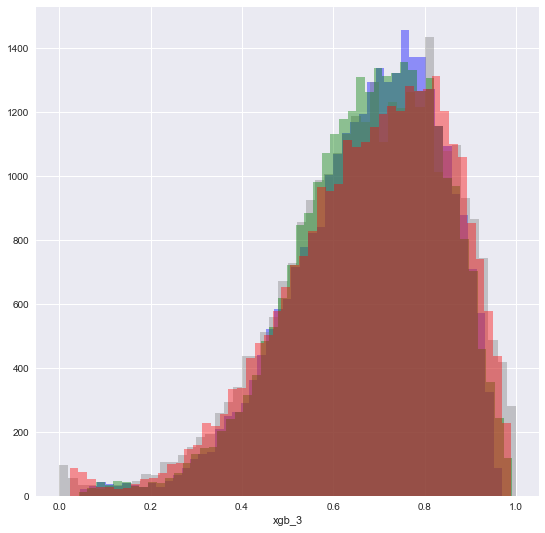

In [53]:
colors = ['blue', 'gray', 'green', 'red']

fig, ax = plt.subplots()
fig.set_size_inches(9, 9);
for col, color in zip(df_predict.drop('obs', axis = 1).columns, colors):
    _ = sns.distplot(df_predict[col], kde = False, color = color);

Although the predictions of all four models are similar overall, there are probability ranges where the models perform differently. For example, the first random forest (gray) makes the most extreme predictions. 

## Ensemble voting 

To overcome the weaknesses of any individual model, it is common to combine multiple models to obtain final predictions. In ensemble models, the predictions of individually calibrated models can be averaged to achieve final predictions that can give better predictions than any individual classifier.

In [163]:
eclf = VotingClassifier(estimators = [
    ('lr', logit), ('rf', rf_1), ('xgb', xgb_3)],
    voting = 'soft', weights = [1, 1, 2])

As the gradient boosted tree classifier performed the best individually, let's weight this model more heavily than the other two models.

In [164]:
wv.cross_val_LL(eclf, X_woe_imputed, y_vector, kfold)

(-0.55448830852481124, 0.0036930911647835465)

In [165]:
eclf_fit = eclf.fit(X_train_full, y_vector)
to_submit6 = wv.for_submission(eclf_fit, X_test_full, series_id, 6)
to_submit6.tail()

,Id,voted
39505,39506,0.845237
39506,39507,0.846536
39507,39508,0.813295
39508,39509,0.477712
39509,39510,0.491258


The public and private leaderboard scores from this submission were 0.55036 and 0.55183, respectively.

Viewing the prediction distributions in the distplot above, we can see the predictions given by the second random forest (green) are most different from the XGBoost model. Therefore let's train an ensemble model with all four models.

In [184]:
eclf2 = VotingClassifier(estimators = [
    ('lr', logit), ('rf', rf_1), ('rf', rf_2), ('xgb', xgb_3)],
    voting = 'soft', weights = [1, 1, 1, 3])

Grid search (not shown) suggests giving the XGBoost model a weight of 3 results in the lowest log-loss score.

In [185]:
wv.cross_val_LL(eclf2, X_woe_imputed, y_vector, kfold)

(-0.55421127565951434, 0.0037041608773769547)

In [186]:
eclf2_fit = eclf2.fit(X_train_full, y_vector)
to_submit7 = wv.for_submission(eclf2_fit, X_test_full, series_id, 7)
to_submit7.tail()

,Id,voted
39505,39506,0.840061
39506,39507,0.850196
39507,39508,0.824467
39508,39509,0.475766
39509,39510,0.490968


This classifier resulted in log-loss scores of 0.55004 (public) and 0.55158 (private).

## Stacking models

As opposed to ensemble methods where the final prediction is a weighted average or vote, stacking involves taking the probability predictions from individually tuned models and using these probabilities as a training set for a meta-classifier to produce final predictions.

In [566]:
meta_clf = XGBClassifier()
sclf = StackingCVClassifier(classifiers = [logit, rf_1, rf_2, xgb_3],
                            use_probas = True,
                            meta_classifier = meta_clf,
                            random_state = 42)

wv.cross_val_LL(sclf, X_woe_imputed, y_vector, kfold)

(-0.5545367030834748, 0.0038581139531508172)

In [540]:
sclf_fit = sclf.fit(X_train_full, y_vector)
to_submit10 = wv.for_submission(sclf, X_test_full, series_id, 10)
to_submit10.tail()

,Id,voted
39505,39506,0.845467
39506,39507,0.841269
39507,39508,0.836503
39508,39509,0.485742
39509,39510,0.495457


This submission resulted in public and private log-loss scores of 0.54996 and 0.55156, respectively.

## Feature importances

Although it is difficult to investigate feature importances of the entire ensemble or stacked model, we can examine the feature importance scores of the individual models. Let's first look at the tree-based models.

In [82]:
#Train the second random forest
rf_2_fit = rf_2.fit(X_train_full, y_vector)

In [105]:
fitted = [rf_1_fit, rf_2_fit, xgb_3_fit]
names = ['rf1', 'rf2', 'xgb3']
list_importances = []
for fit, name in zip(fitted, names):
    feat = wv.find_important_features(train_imp, fit, 
                                      categ_card, quant_card, 
                                      col2 = name)
    list_importances.append(feat)

In [108]:
for i in list_importances:
    i.tail()

,features,rf1
2,state_house,0.049366
0,gender,0.018311
3,age,0.017131
14,dist_ballot,0.007234
15,dist_poll,0.000115


,features,rf2
8,children,0.057868
0,gender,0.029696
14,dist_ballot,0.015317
3,age,0.013257
15,dist_poll,0.000004


,features,xgb3
2,state_house,0.053414
3,age,0.020218
0,gender,0.020153
14,dist_ballot,0.006881
15,dist_poll,0.000163


We see that in all three models the dist variables are ranked very low. Let's try training the stacked classifier without the presence of these two variables.

### Removing distance columns (imputed data)

In [567]:
wv.cross_val_LL(sclf, X_woe, y_vector, kfold)

(-0.55465009977429791, 0.0037332539486871459)

The log-loss is lower compared to the classifier trained on the matrix containing the imputed data. Let's also see if using fewer individual models for the stacking classifier results in better performance.

In [568]:
sclf2 = StackingCVClassifier(classifiers = [logit, rf_2, xgb_3],
                            use_probas = True,
                            meta_classifier = meta_clf,
                            random_state = 42)

wv.cross_val_LL(sclf2, X_woe, y_vector, kfold)

(-0.55479833372607268, 0.0037889816080180008)

In [569]:
sclf3 = StackingCVClassifier(classifiers = [logit, xgb_3],
                            use_probas = True,
                            meta_classifier = meta_clf,
                            random_state = 42)

wv.cross_val_LL(sclf3, X_woe, y_vector, kfold)

(-0.55522346867976935, 0.0036879204991137485)

In [570]:
meta_clf = XGBClassifier()
sclf4 = StackingCVClassifier(classifiers = [logit, rf_1, xgb_3],
                            use_probas = True,
                            meta_classifier = meta_clf,
                            random_state = 42)

wv.cross_val_LL(sclf4, X_woe, y_vector, kfold)

(-0.55468384387783121, 0.0036940756573150446)

Using 4 individual classifiers still leads to the best performance as evaluated by cross-validation.

Let's create the new test matrix.

In [114]:
X_test_nodist = X_df.iloc[118529:, ].drop(['dist_poll', 'dist_ballot'], axis = 1).as_matrix()

In [575]:
sclf_fit_nodist = sclf.fit(X_woe, y_vector)
submit_12 = wv.for_submission(sclf_fit_nodist, X_test_nodist, series_id, 12)
submit_12.head()

,Id,voted
0,1,0.643778
1,2,0.480491
2,3,0.706415
3,4,0.622526
4,5,0.807769


This submission resulted in public and private log-loss scores of 0.54943 and 0.55155, respectively.

## Transforming all categorical variables

Originally party and gender were one-hot-encoded rather than transformed using WOE. However, party still has a larger number of categories relative to the total number of features. Let's test whether transforming all the categorical variables (and dropping the distance variables) results in better performance.

In [124]:
all_woes = []
#transform all categorical variables
for i in categ:
    _, woe = wv.transform_to_continuous(train_imp, i, voted_counts)
    all_woes.append(woe)

train_all_woe = wv.create_card_df(train_imp, categ, all_woes)
train_all_woe.head()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll,voted
0,-0.165044,0.044297,-0.075085,36,-0.381198,-0.434060,25.4,63.4,54.0,16.7,16.5,39.6,27.3,420,2.658148,3.456541,Y
1,0.178863,0.056369,0.378928,55,-0.381198,0.080037,7.9,97.8,59.8,16.7,15.5,30.9,36.9,307,2.240415,2.130636,Y
2,0.178863,0.285996,0.375024,24,-0.381198,0.066171,50.2,7.6,49.5,14.6,24.0,29.6,31.7,292,2.332767,2.872147,Y
3,0.178863,0.044297,-0.167379,25,0.396916,0.066171,38.0,8.5,47.4,13.1,22.3,33.3,31.4,316,2.983480,3.193841,Y
4,-0.165044,-0.172422,0.401082,22,0.339505,0.066171,30.5,19.1,23.1,16.0,10.5,39.1,34.5,392,3.160107,3.841248,Y


In [125]:
#drop response and dist_
train_all_woe.drop(['voted', 'dist_ballot', 'dist_poll'],
                  axis = 1, inplace = True)

#normalize all variables
train_all_woe = (train_all_woe - train_all_woe.mean()) / train_all_woe.std()
train_all_woe.head()

X_all_woe = train_all_woe.as_matrix()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg
0,-0.988270,0.160564,-0.205271,0.021008,-1.085858,-2.428058,0.163349,0.598340,1.006435,0.743003,0.109214,-0.109643,-1.023448,-0.359789
1,1.006917,0.214521,0.792340,1.233787,-1.085858,0.414434,-1.007899,1.684611,1.287718,0.743003,-0.045930,-0.937032,1.540124,-1.392784
2,1.006917,1.240874,0.783762,-0.744957,-1.085858,0.337771,1.823175,-1.163692,0.788199,0.386895,1.272794,-1.060665,0.151523,-1.529907
3,1.006917,0.160564,-0.408070,-0.681127,0.996590,0.337771,1.006647,-1.135273,0.686355,0.132531,1.009049,-0.708787,0.071411,-1.310510
4,-0.988270,-0.808095,0.841021,-0.872618,0.842944,0.337771,0.504684,-0.800550,-0.492123,0.624300,-0.821650,-0.157195,0.899231,-0.615752


In [126]:
X_all_woe.shape
y_vector.shape

(118529, 14)

(118529,)

In [129]:
wv.cross_val_LL(sclf, X_all_woe, y_vector, kfold)

(-0.55456212066322985, 0.0038112458042181135)

In [130]:
#create new train and test sets
train_test = wv.create_card_df(all_data, categ, all_woes)
train_test = train_test.drop(['dist_ballot', 'dist_poll'], axis = 1)
train_test = (train_test - train_test.mean()) / train_test.std()

X_train_card = train_test.iloc[:118529, ].as_matrix()
X_test_card = train_test.iloc[118529:, ].as_matrix()

In [634]:
sclf_fit_final = sclf(X_train_card, y_vector)
to_submit14 = wv.for_submission(sclf_fit_final, X_test_card, series_id, 14)
to_submit14.head()

,Id,voted
0,1,0.636529
1,2,0.491942
2,3,0.694913
3,4,0.612622
4,5,0.816451


The public log-loss score from this submission was 0.5491. The final score is 0.55154, and my final rank is 5 out of 40 in this [competition](https://inclass.kaggle.com/c/who-voted/leaderboard).

Let's save predictions from the final stacked classifier, the individually fitted models and the test and train matrices for further analysis and future reference.

In [ ]:
#get predictions from final model
predictions = sclf_fit_final.predict_proba(X_test_card)

#save probabilities with predictor information
pred_test = test_imp.copy()
pred_test['voted_proba'] = predictions[:, 1]
pred_test.to_csv('pred_test.csv', index = False)

In [133]:
#train individual models on final predictors
logit_fit_final = logit.fit(X_train_card, y_vector)
xgb_fit_final = xgb_3.fit(X_train_card, y_vector)
rf1_fit_final = rf_1.fit(X_train_card, y_vector)
rf2_fit_final = rf_2.fit(X_train_card, y_vector)

In [134]:
#save trained models
final_models = [sclf_fit_final, logit_fit_final, 
                xgb_fit_final, rf1_fit_final, rf2_fit_final]
file_names = ['final_sclf', 'final_logit', 'final_xgb', 'final_rf1', 'final_rf2']

for model, name in zip(final_models, file_names):
    joblib.dump(model, '{}.pkl'.format(name))

['final_sclf.pkl']

['final_logit.pkl']

['final_xgb.pkl']

['final_rf1.pkl']

['final_rf2.pkl']

In [135]:
matrices = [X_train_card, y_vector, X_test_card]
matrix_names = ['final_train', 'final_y', 'final_test']

for m, n in zip(matrices, matrix_names):
    np.savetxt('{}.csv'.format(n), m, delimiter = ',')

See [part 5](who-voted_final.ipynb) for model interpretation and final analyses.